In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
pip install --upgrade tensorflow==2.13.0

In [1]:
import tensorflow as tf
tf_version = tf.__version__

print("TensorFlow version:", tf_version)

TensorFlow version: 2.13.0


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import metrics, Model, layers
from tensorflow.keras import layers, models, optimizers
from pathlib import Path
from PIL import Image

2024-04-09 06:22:08.872632: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 06:22:08.872770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 06:22:09.033341: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from pathlib import Path
import os
import cv2

# Set the data directory path
data_dir = '/kaggle/input/cellimagesfordetectingmalaria/cell_images'

# Create the paths for parasitized and uninfected images
parasitized_data = list(Path(os.path.join(data_dir, 'Parasitized')).rglob('*.png'))
uninfected_data = list(Path(os.path.join(data_dir, 'Uninfected')).rglob('*.png'))

data = []
labels = []
IMG_SIZE = 130

In [3]:
for img_path in parasitized_data:
    try:
        img = cv2.imread(str(img_path))
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img_array = np.array(img)
        data.append(img_array)
        labels.append(1)
    except Exception as e:
        print(f"Error loading parasitized image {img_path}: {e}")

# Load uninfected images
for img_path in uninfected_data:
    try:
        img = cv2.imread(str(img_path))
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img_array = np.array(img)
        data.append(img_array)
        labels.append(0)
    except Exception as e:
        print(f"Error loading uninfected image {img_path}: {e}")

image_data = np.array(data)
labels = np.array(labels)

print("image_data shape:", image_data.shape)
print("labels shape:", labels.shape)

image_data shape: (27558, 130, 130, 3)
labels shape: (27558,)


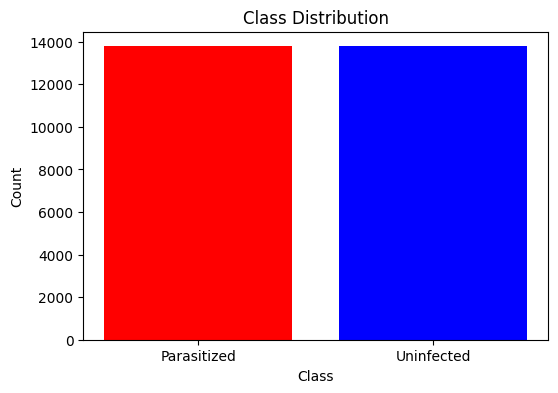

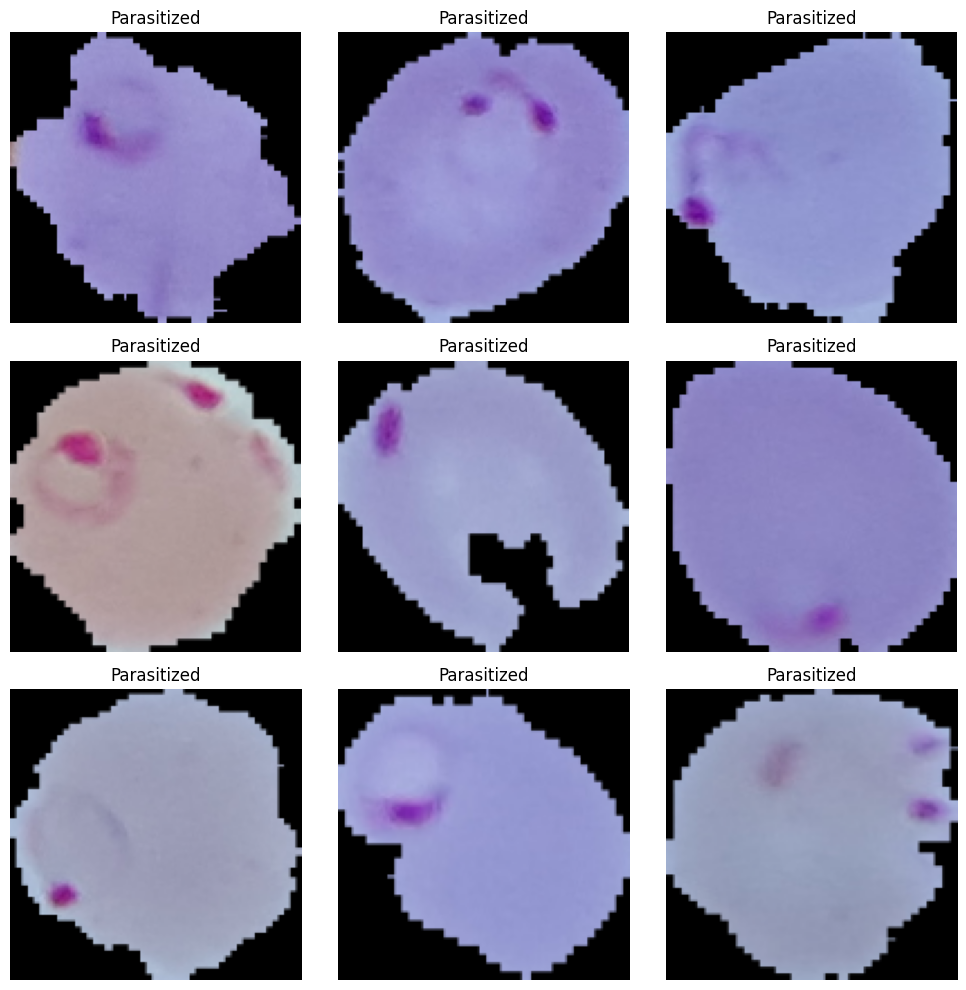

In [17]:
import matplotlib.pyplot as plt

# Class Distribution Bar Plot
plt.figure(figsize=(6, 4))
plt.bar(['Parasitized', 'Uninfected'], [np.sum(labels==1), np.sum(labels==0)], color=['red', 'blue'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Sample Images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(image_data[i])
    if labels[i] == 1:
        plt.title('Parasitized')
    else:
        plt.title('Uninfected')
    plt.axis('off')
plt.tight_layout()
plt.show()


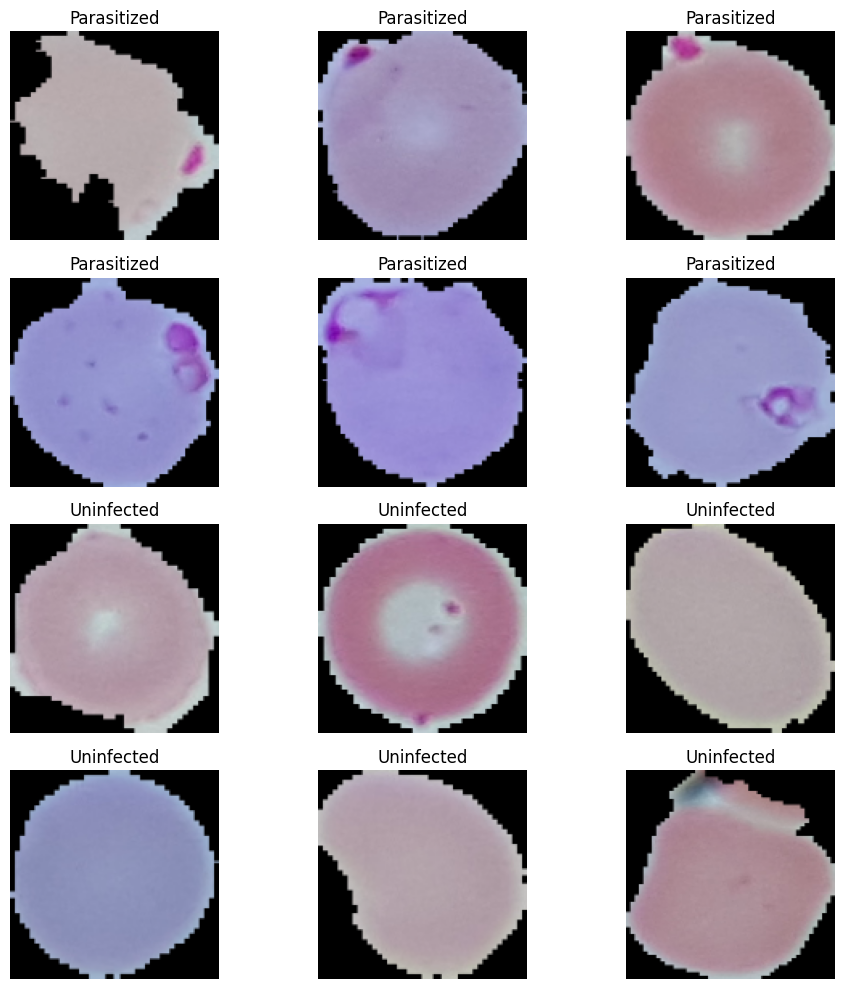

In [22]:
import matplotlib.pyplot as plt
import random
num_images = 12
num_rows = 4
num_cols = 3
# Get random indices for each class
parasitized_indices = np.where(labels == 1)[0]
uninfected_indices = np.where(labels == 0)[0]
# Choose random indices from each class
random_parasitized_indices = random.sample(list(parasitized_indices), num_images // 2)
random_uninfected_indices = random.sample(list(uninfected_indices), num_images // 2)
# Plot random images
plt.figure(figsize=(10, 10))
# Plot parasitized images
for i, idx in enumerate(random_parasitized_indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(image_data[idx])
    plt.title('Parasitized')
    plt.axis('off')
# Plot uninfected images
for i, idx in enumerate(random_uninfected_indices):
    plt.subplot(num_rows, num_cols, i + num_images // 2 + 1)
    plt.imshow(image_data[idx])
    plt.title('Uninfected')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

# Shuffle the indices of the dataset
indices = np.arange(len(image_data))
np.random.shuffle(indices)

# Use the shuffled indices to shuffle the dataset
shuffled_image_data = image_data[indices]
shuffled_labels = labels[indices]

# Split the shuffled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(shuffled_image_data, shuffled_labels, test_size=0.2, random_state=0)

# Normalize the pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes=2)
y_test = keras.utils.to_categorical(y_test, num_classes=2)


In [6]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
    

In [7]:
datagen.fit(X_train)

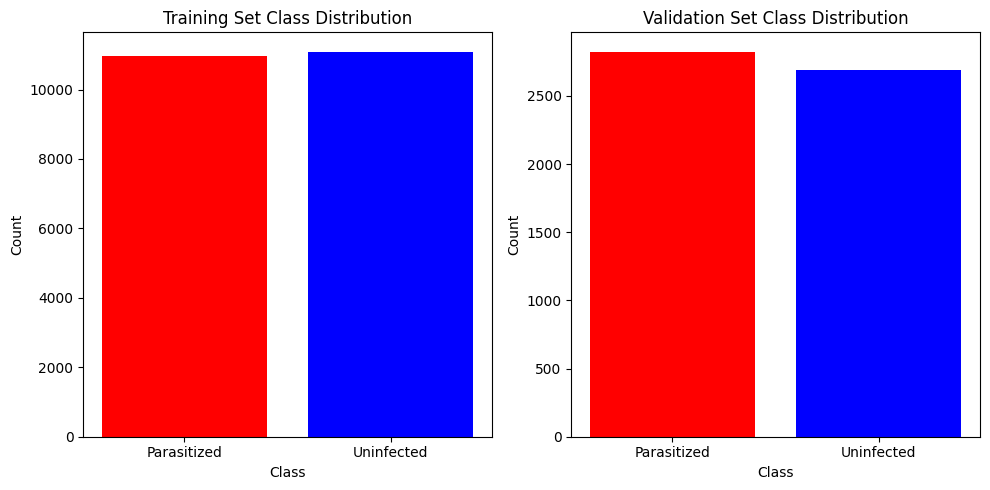

In [8]:
import matplotlib.pyplot as plt

# Calculate the number of parasitized and uninfected samples in training and testing sets
train_parasitized_count = np.sum(y_train[:, 1])
train_uninfected_count = np.sum(y_train[:, 0])
test_parasitized_count = np.sum(y_test[:, 1])
test_uninfected_count = np.sum(y_test[:, 0])

# Plot the counts in two different graphs
plt.figure(figsize=(10, 5))

# Plot training set counts
plt.subplot(1, 2, 1)
plt.bar(['Parasitized', 'Uninfected'], [train_parasitized_count, train_uninfected_count], color=['red', 'blue'])
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Plot testing set counts
plt.subplot(1, 2, 2)
plt.bar(['Parasitized', 'Uninfected'], [test_parasitized_count, test_uninfected_count], color=['red', 'blue'])
plt.title('Validation Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()
